In [77]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

Read the data from csv file

In [78]:
train = pd.read_csv("C:/Users/USER/OneDrive/Documents/Data Mining Assignement 2/covid-19_vaccine_tweets_with_sentiment.csv", encoding= 'unicode_escape')

In [79]:
train

,tweet_id,label,tweet_text
0,1360340000000000000,1.0,"4,000 a day dying from the so called Covid-19 ..."
1,1382900000000000000,2.0,Pranam message for today manifested in Dhyan b...
2,1375670000000000000,2.0,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1381310000000000000,1.0,"Confirmation that Chinese #vaccines ""donÖÉ hav..."
4,1362170000000000000,3.0,"Lab studies suggest #Pfizer, #Moderna vaccines..."
...,...,...,...
5995,1370980000000000000,2.0,@Swamy39 Dr. @Swamy39 jee :\n\nMany people lik...
5996,1379830000000000000,3.0,So happy to be fully vaccinated against COVID-...
5997,1384790000000000000,2.0,Serum Institute of India announces cost of Cov...
5998,1382360000000000000,1.0,@___batshitcrazy @BarrowfordHead @Bectully I h...


In [80]:
def partistion(x):
    if x == 1:
        return "negative"
    elif x == 2:
        return "neutral"
    return "positive"

In [81]:
ActualLabel = train['label']
PositiveNegative = ActualLabel.map(partistion)
train['label'] = PositiveNegative

train.shape
train

,tweet_id,label,tweet_text
0,1360340000000000000,negative,"4,000 a day dying from the so called Covid-19 ..."
1,1382900000000000000,neutral,Pranam message for today manifested in Dhyan b...
2,1375670000000000000,neutral,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1381310000000000000,negative,"Confirmation that Chinese #vaccines ""donÖÉ hav..."
4,1362170000000000000,positive,"Lab studies suggest #Pfizer, #Moderna vaccines..."
...,...,...,...
5995,1370980000000000000,neutral,@Swamy39 Dr. @Swamy39 jee :\n\nMany people lik...
5996,1379830000000000000,positive,So happy to be fully vaccinated against COVID-...
5997,1384790000000000000,neutral,Serum Institute of India announces cost of Cov...
5998,1382360000000000000,negative,@___batshitcrazy @BarrowfordHead @Bectully I h...


Data Preparation

Removing the records with the not numerical id

In [82]:
train = train[pd.to_numeric(train['tweet_id'], errors='coerce').notnull()]
train

,tweet_id,label,tweet_text
0,1360340000000000000,negative,"4,000 a day dying from the so called Covid-19 ..."
1,1382900000000000000,neutral,Pranam message for today manifested in Dhyan b...
2,1375670000000000000,neutral,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1381310000000000000,negative,"Confirmation that Chinese #vaccines ""donÖÉ hav..."
4,1362170000000000000,positive,"Lab studies suggest #Pfizer, #Moderna vaccines..."
...,...,...,...
5995,1370980000000000000,neutral,@Swamy39 Dr. @Swamy39 jee :\n\nMany people lik...
5996,1379830000000000000,positive,So happy to be fully vaccinated against COVID-...
5997,1384790000000000000,neutral,Serum Institute of India announces cost of Cov...
5998,1382360000000000000,negative,@___batshitcrazy @BarrowfordHead @Bectully I h...


Finding the duplicated data and the different label with same text. Hence, need to handle these data. There are two scenarios in this dataset, which are the duplicated data with same value of label for the same tweet_text and the duplicated data with different value of label for the same tweet_text.

In [83]:
tweetText = train['tweet_text']
label = train['label']
test = train[tweetText.isin(tweetText[tweetText.duplicated()])].sort_values("tweet_text")
test

,tweet_id,label,tweet_text
1260,1375880000000000000,neutral,#Pfizer's version requires a 21-day space peri...
5642,1374430000000000000,neutral,#Pfizer's version requires a 21-day space peri...
1466,1376720000000000000,neutral,'Dr Reddy's expects #SputnikV vaccine to get a...
2165,1376450000000000000,positive,'Dr Reddy's expects #SputnikV vaccine to get a...
111,1382790000000000000,positive,@CP24 While Canada is forced to stay at home h...
2592,1382790000000000000,neutral,@CP24 While Canada is forced to stay at home h...
2415,1367110000000000000,positive,Bharat Biotech says #Covaxin shows interim vac...
4212,1367100000000000000,neutral,Bharat Biotech says #Covaxin shows interim vac...
2560,1384260000000000000,positive,Got my second dose of the #Moderna #vaccine to...
2731,1384280000000000000,positive,Got my second dose of the #Moderna #vaccine to...


Hence, for the duplicated data with different value of label for the same tweet_text, since we cannot determine which label is suitable for the particular tweet_text. Thus, I am eliminated these data records.

In [84]:
train = train.drop(index=[111,2592,2415,4212,1466,2165])
train

,tweet_id,label,tweet_text
0,1360340000000000000,negative,"4,000 a day dying from the so called Covid-19 ..."
1,1382900000000000000,neutral,Pranam message for today manifested in Dhyan b...
2,1375670000000000000,neutral,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1381310000000000000,negative,"Confirmation that Chinese #vaccines ""donÖÉ hav..."
4,1362170000000000000,positive,"Lab studies suggest #Pfizer, #Moderna vaccines..."
...,...,...,...
5995,1370980000000000000,neutral,@Swamy39 Dr. @Swamy39 jee :\n\nMany people lik...
5996,1379830000000000000,positive,So happy to be fully vaccinated against COVID-...
5997,1384790000000000000,neutral,Serum Institute of India announces cost of Cov...
5998,1382360000000000000,negative,@___batshitcrazy @BarrowfordHead @Bectully I h...


For the duplicated data with same value of label for the same tweet_text, in order to reduce the redundancy of the dataset, I remove the duplicated records by keeping only the first records if the label and twet_text are the same. 

In [85]:
final = train.drop_duplicates(subset=('label','tweet_text'),keep='first',inplace=False)
final

,tweet_id,label,tweet_text
0,1360340000000000000,negative,"4,000 a day dying from the so called Covid-19 ..."
1,1382900000000000000,neutral,Pranam message for today manifested in Dhyan b...
2,1375670000000000000,neutral,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1381310000000000000,negative,"Confirmation that Chinese #vaccines ""donÖÉ hav..."
4,1362170000000000000,positive,"Lab studies suggest #Pfizer, #Moderna vaccines..."
...,...,...,...
5995,1370980000000000000,neutral,@Swamy39 Dr. @Swamy39 jee :\n\nMany people lik...
5996,1379830000000000000,positive,So happy to be fully vaccinated against COVID-...
5997,1384790000000000000,neutral,Serum Institute of India announces cost of Cov...
5998,1382360000000000000,negative,@___batshitcrazy @BarrowfordHead @Bectully I h...


Now, Removing Noise from the Data will be carried out.

In [86]:
from bs4 import BeautifulSoup

Checking if the html tag exist in the tweet_text. The result shows there is no html tag contained in the tweet_text.

In [87]:
i = 0;
for sent in final['tweet_text'].values:
    if (bool(BeautifulSoup(sent, "html.parser").find())):
        print(i)
        print(sent)
        break;
    i +=1

In [88]:
print(final['tweet_text'].iloc[1])

Pranam message for today manifested in Dhyan by @meenapranam #truth #love #karm #light #nature #consciousness #FridayThoughts #fridaymorning #CoronavirusIndia #COVID19India #?????_???????? #navratri #Thane #AmbedkarJayanti2021 #ModiJi #NarendraModi #SecondCOVIDWave #Covaxin https://t.co/bQNoMVowJg


Have found that URL link and @tag are existed in the tweet_text, hence, the URL link and teh @tag with the account name after @tag need to be removed. 

Therefore, the function of cleanpunc() is used to clean all the word of any punctuation, and function cleanurl is used to clean the word of any url link.

In [89]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemming

def cleanpunc(sentence): #function to clean the word of any punctuation
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [90]:
def cleanurl(sentence): #function to clean the word of any url link
    cleantext = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
    cleantext = re.sub("(@[A-Za-z0-9_]+)","", sentence)
    return cleantext

tokenization

Then, the tokennization can be carried out while cleaning the text. Hence, I store all the positive words in to the array of "all_positive_words", all the negative words in to the array of "negative_words" and all the neutral words in to the array of "all_neutral_words".

Then, create a new column to add the cleaned text into the dataset.

In [91]:
i = 0
str1 = ' '
final_string = []
all_positive_words = [] #store words from +ve reviews here
all_negative_words = [] #store words from -ve reviews here
all_neutral_words = [] #store words from neutral reviews here
s = ''
for sent in final['tweet_text'].values:
    filtered_sentence=[]
    sent = cleanurl(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['label'].values)[i]=='positive':
                        all_positive_words.append(s) #list of all words that are positve
                    if (final['label'].values)[i]=='negative':
                        all_negative_words.append(s) #list of all words that are negative
                    if (final['label'].values)[i]=='neutral':
                        all_neutral_words.append(s) #list of all words that are neural
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i +=1

In [92]:
final['CleanedText']=final_string #adding a column of cleanedtext to final

To check all the noise such as URL link and @tag are removed.

In [93]:
print(final['CleanedText'].iloc[1])

b'pranam messag today manifest dhyan truth love karm light natur conscious fridaythought fridaymorn coronavirusindia navratri thane modiji narendramodi secondcovidwav covaxin bqnomvowjg'


In [153]:
final

,label,tweet_id,tweet_text,CleanedText
0,negative,1360340000000000000,"4,000 a day dying from the so called Covid-19 ...",b'day die call \xc3\xad\xc3\xa2accin report va...
1,negative,1381310000000000000,"Confirmation that Chinese #vaccines ""donÖÉ hav...",b'confirm chines vaccin don\xc3\xb6\xc3\xa9 hi...
2,positive,1362170000000000000,"Lab studies suggest #Pfizer, #Moderna vaccines...",b'lab studi suggest pfizer moderna vaccin prot...
3,negative,1351290000000000000,Still want to take the #jab?\n#PfizerBioNTech\...,b'still want take jab pfizerbiontech sideeffec...
4,positive,1363340000000000000,#Covaxin effective against mutant virus strain...,b'covaxin effect mutant virus icmr thank jee h...
...,...,...,...,...
2309,positive,1385050000000000000,To all stil in confusion about vaccine pls int...,b'stil confus vaccin pls interpret data proper...
2310,positive,1380180000000000000,"24 hours since second #moderna shot. So far, I...",b'hour sinc second moderna shot far feel super...
2311,positive,1373030000000000000,my mom just got vaccinated ?? #Moderna,b'mom got vaccin moderna'
2312,positive,1379830000000000000,So happy to be fully vaccinated against COVID-...,b'happi fulli vaccin i\xc3\xb6\xc2\xaa readi s...


In [95]:
len(all_positive_words)

26457

In [96]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)
freq_dist_neutral = nltk.FreqDist(all_neutral_words)
print("Most Common Positive words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))
print("Most Common Negative Words : ",freq_dist_neutral.most_common(20))

Most Common Positive words :  [(b'vaccin', 1676), (b'moderna', 909), (b'covaxin', 376), (b'get', 375), (b'dose', 361), (b'first', 314), (b'got', 308), (b'effect', 277), (b'covidvaccin', 277), (b'shot', 264), (b'pfizerbiontech', 262), (b'sputnikv', 255), (b'today', 232), (b'thank', 231), (b'case', 162), (b'covid', 156), (b'busi', 148), (b'pfizer', 147), (b'oxfordastrazeneca', 145), (b'second', 134)]
Most Common Negative Words :  [(b'vaccin', 358), (b'moderna', 206), (b'pfizer', 73), (b'effect', 58), (b'oxfordastrazeneca', 55), (b'peopl', 54), (b'astrazeneca', 52), (b'covaxin', 51), (b'pfizerbiontech', 50), (b'sputnikv', 50), (b'get', 48), (b'shot', 46), (b'dose', 46), (b'covid', 45), (b'day', 43), (b'got', 40), (b'like', 38), (b'sinovac', 36), (b'coronavirus', 34), (b'one', 34)]
Most Common Negative Words :  [(b'vaccin', 2878), (b'moderna', 1232), (b'covaxin', 1001), (b'sputnikv', 767), (b'dose', 698), (b'pfizer', 512), (b'get', 404), (b'pfizerbiontech', 398), (b'covidvaccin', 385), (b'

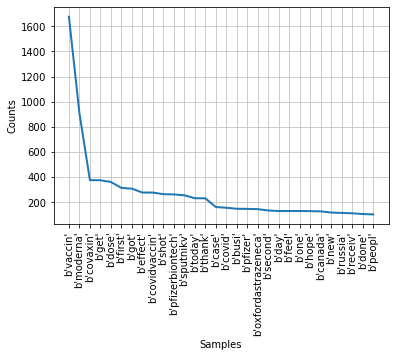

In [97]:
import matplotlib.pyplot as plt
freq_dist_positive.plot(30,cumulative=False)
plt.show()

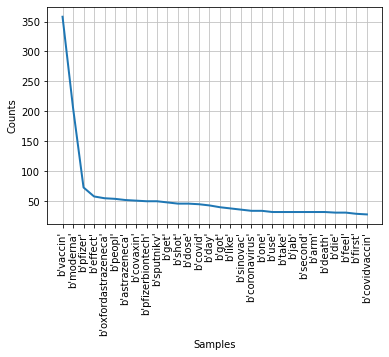

In [98]:
import matplotlib.pyplot as plt
freq_dist_negative.plot(30,cumulative=False)
plt.show()

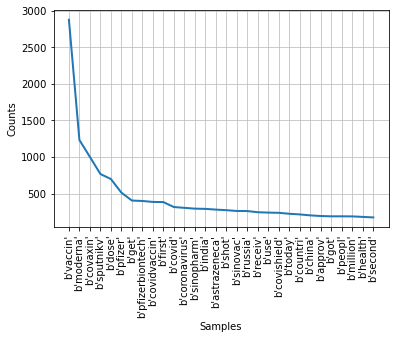

In [99]:
import matplotlib.pyplot as plt
freq_dist_neutral.plot(30,cumulative=False)
plt.show()

Bag-of-words (BOW) model

Now, after all the data preparation, the Feature Enginerring process can be carried out. The Bag-of-words is developed.

In [100]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values.tolist())

In [101]:
count_vect.vocabulary_

{'day': 2268,
 'die': 2461,
 'call': 1305,
 'íâaccin': 10634,
 'report': 7699,
 'vaccin': 9741,
 'pfizervaccin': 6928,
 'moderna': 5922,
 'pranam': 7158,
 'messag': 5790,
 'today': 9314,
 'manifest': 5607,
 'dhyan': 2442,
 'truth': 9456,
 'love': 5466,
 'karm': 4967,
 'light': 5341,
 'natur': 6172,
 'conscious': 1843,
 'fridaythought': 3526,
 'fridaymorn': 3525,
 'coronavirusindia': 1941,
 'navratri': 6180,
 'thane': 9113,
 'modiji': 5947,
 'narendramodi': 6151,
 'secondcovidwav': 8122,
 'covaxin': 2003,
 'bqnomvowjg': 1129,
 'sought': 8535,
 'fund': 3573,
 'govern': 3831,
 'ramp': 7513,
 'product': 7250,
 'indigen': 4552,
 'develop': 2420,
 'compani': 1772,
 'written': 10390,
 'seek': 8137,
 'crore': 2140,
 'confirm': 1821,
 'chines': 1563,
 'donöé': 2645,
 'high': 4169,
 'protect': 7286,
 'rate': 7536,
 'accord': 62,
 'director': 2496,
 'china': 1557,
 'center': 1453,
 'diseas': 2523,
 'control': 1887,
 'gao': 3623,
 'sinovac': 8369,
 'effect': 2838,
 'found': 3472,
 'low': 5468,
 'r

In [102]:
count_vect.transform(final['CleanedText'].values).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [103]:
final_counts.shape

(5982, 10645)

There are 5988 row of data records with 10525 features in the final_counts dataset.

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_counts, final['label'], test_size=0.2, random_state=1)

In [105]:
X_train

<4785x10645 sparse matrix of type '<class 'numpy.int64'>'
	with 65180 stored elements in Compressed Sparse Row format>

In [106]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6675020885547202


The accuracy is low, hence I remove the records with label "nuetral" in order to improve the accuracy. By setting the "label" as the index for the dataset, and removing all the records with the neutral label. After all the data preprocessing, I reset the index for the dataset, in order to ease the following data handling. 

In [107]:
final_with_index = final.set_index("label")
final = final_with_index.drop("neutral")
final

,tweet_id,tweet_text,CleanedText
label,,,
negative,1360340000000000000,"4,000 a day dying from the so called Covid-19 ...",b'day die call \xc3\xad\xc3\xa2accin report va...
negative,1381310000000000000,"Confirmation that Chinese #vaccines ""donÖÉ hav...",b'confirm chines vaccin don\xc3\xb6\xc3\xa9 hi...
positive,1362170000000000000,"Lab studies suggest #Pfizer, #Moderna vaccines...",b'lab studi suggest pfizer moderna vaccin prot...
negative,1351290000000000000,Still want to take the #jab?\n#PfizerBioNTech\...,b'still want take jab pfizerbiontech sideeffec...
positive,1363340000000000000,#Covaxin effective against mutant virus strain...,b'covaxin effect mutant virus icmr thank jee h...
...,...,...,...
positive,1385050000000000000,To all stil in confusion about vaccine pls int...,b'stil confus vaccin pls interpret data proper...
positive,1380180000000000000,"24 hours since second #moderna shot. So far, I...",b'hour sinc second moderna shot far feel super...
positive,1373030000000000000,my mom just got vaccinated ?? #Moderna,b'mom got vaccin moderna'


In [108]:
final.reset_index(inplace = True)
final

,label,tweet_id,tweet_text,CleanedText
0,negative,1360340000000000000,"4,000 a day dying from the so called Covid-19 ...",b'day die call \xc3\xad\xc3\xa2accin report va...
1,negative,1381310000000000000,"Confirmation that Chinese #vaccines ""donÖÉ hav...",b'confirm chines vaccin don\xc3\xb6\xc3\xa9 hi...
2,positive,1362170000000000000,"Lab studies suggest #Pfizer, #Moderna vaccines...",b'lab studi suggest pfizer moderna vaccin prot...
3,negative,1351290000000000000,Still want to take the #jab?\n#PfizerBioNTech\...,b'still want take jab pfizerbiontech sideeffec...
4,positive,1363340000000000000,#Covaxin effective against mutant virus strain...,b'covaxin effect mutant virus icmr thank jee h...
...,...,...,...,...
2309,positive,1385050000000000000,To all stil in confusion about vaccine pls int...,b'stil confus vaccin pls interpret data proper...
2310,positive,1380180000000000000,"24 hours since second #moderna shot. So far, I...",b'hour sinc second moderna shot far feel super...
2311,positive,1373030000000000000,my mom just got vaccinated ?? #Moderna,b'mom got vaccin moderna'
2312,positive,1379830000000000000,So happy to be fully vaccinated against COVID-...,b'happi fulli vaccin i\xc3\xb6\xc2\xaa readi s...


Hence, I use the dataset that have been removed the label of neutral to develop the feature enginerring. 

In [109]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values.tolist())

In [110]:
count_vect.vocabulary_

{'day': 1108,
 'die': 1195,
 'call': 613,
 'íâaccin': 5240,
 'report': 3760,
 'vaccin': 4786,
 'pfizervaccin': 3369,
 'moderna': 2888,
 'confirm': 876,
 'chines': 742,
 'donöé': 1280,
 'high': 2035,
 'protect': 3556,
 'rate': 3661,
 'accord': 26,
 'director': 1210,
 'china': 738,
 'center': 682,
 'diseas': 1220,
 'control': 915,
 'gao': 1773,
 'sinovac': 4077,
 'effect': 1382,
 'found': 1699,
 'low': 2660,
 'research': 3767,
 'use': 4772,
 'lab': 2493,
 'studi': 4307,
 'suggest': 4333,
 'pfizer': 3364,
 'coronavirusvari': 952,
 'still': 4264,
 'want': 4974,
 'take': 4390,
 'jab': 2333,
 'pfizerbiontech': 3365,
 'sideeffect': 4054,
 'isra': 2309,
 'suffer': 4328,
 'facial': 1546,
 'paralysi': 3280,
 'covid': 989,
 'amid': 164,
 'influx': 2240,
 'detail': 1174,
 'advers': 66,
 'ryitpgzuav': 3863,
 'covaxin': 981,
 'mutant': 2958,
 'virus': 4920,
 'icmr': 2140,
 'thank': 4457,
 'jee': 2357,
 'health': 1990,
 'minist': 2856,
 'harsh': 1970,
 'vardhan': 4861,
 'promot': 3546,
 'india': 2213

In [111]:
count_vect.transform(final['CleanedText'].values).toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [112]:
final_counts.shape

(2314, 5243)

There are 2316 row of data records with 5185 features in the final_counts dataset.

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_counts, final['label'], test_size=0.2, random_state=1)

In [114]:
X_train

<1851x5243 sparse matrix of type '<class 'numpy.int64'>'
	with 25087 stored elements in Compressed Sparse Row format>

In [115]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

MultinomialNB Accuracy: 0.8617710583153347
[[ 37  44]
 [ 20 362]]


Now in order to improve the accuracy, we try to combine 2 words together by using N-gram method. Then, try to combine 3 words togather. And test the accuracy to determine which feature engineering we needs to go with.

In [116]:
count_vect2 = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect2.fit_transform(final['CleanedText'].values)

In [117]:
final_bigram_counts

<2314x26154 sparse matrix of type '<class 'numpy.int64'>'
	with 61967 stored elements in Compressed Sparse Row format>

In [118]:
features = count_vect2.get_feature_names()
features[10000:10010]

['healthcarehero carenotcovid',
 'healthcarehero coronavirusvaccin',
 'healthcarehero covid',
 'healthcarehero protectourhealthwork',
 'healthcarehero take',
 'healthcarework',
 'healthcarework frontlin',
 'healthcarework inc',
 'healthforal',
 'healthforal led']

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_bigram_counts, final['label'], test_size=0.2, random_state=1)

In [120]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8466522678185745


In [121]:
count_vect3 = CountVectorizer(ngram_range=(1,3))
final_trigram_counts = count_vect3.fit_transform(final['CleanedText'].values)

In [122]:
count_vect3.vocabulary_

{'day': 9854,
 'die': 10832,
 'call': 5000,
 'íâaccin': 51024,
 'report': 35379,
 'vaccin': 45431,
 'pfizervaccin': 32044,
 'moderna': 26411,
 'day die': 9904,
 'die call': 10837,
 'call íâaccin': 5045,
 'íâaccin report': 51025,
 'report vaccin': 35448,
 'vaccin pfizervaccin': 46856,
 'pfizervaccin moderna': 32061,
 'day die call': 9905,
 'die call íâaccin': 10838,
 'call íâaccin report': 5046,
 'íâaccin report vaccin': 51026,
 'report vaccin pfizervaccin': 35449,
 'vaccin pfizervaccin moderna': 46858,
 'confirm': 7110,
 'chines': 6068,
 'donöé': 11584,
 'high': 19804,
 'protect': 33559,
 'rate': 34321,
 'accord': 158,
 'director': 10983,
 'china': 5979,
 'center': 5601,
 'diseas': 11035,
 'control': 7337,
 'gao': 16847,
 'sinovac': 38896,
 'effect': 12584,
 'found': 16268,
 'low': 24737,
 'research': 35491,
 'use': 45224,
 'confirm chines': 7111,
 'chines vaccin': 6090,
 'vaccin donöé': 46010,
 'donöé high': 11597,
 'high protect': 19825,
 'protect rate': 33634,
 'rate accord': 34322,

In [123]:
final_trigram_counts

<2314x51033 sparse matrix of type '<class 'numpy.int64'>'
	with 90525 stored elements in Compressed Sparse Row format>

In [124]:
features = count_vect3.get_feature_names()
features[10000:10010]

['day occasion headach',
 'day one',
 'day one die',
 'day one know',
 'day one step',
 'day oxfordastrazeneca',
 'day oxfordastrazeneca vacin',
 'day pakistani',
 'day pakistani presid',
 'day part']

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_trigram_counts, final['label'], test_size=0.2, random_state=1)

In [126]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.7904967602591793


The result of the increament of the combination of N-term DO NOT improve the accuracy, hence, for the following development, the model without processed by Ngram method will be used.

TF-IDF

Now, I am going to use the TF-IDF to further develop the feature engineering.

In [127]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [128]:
final_tf_idf.shape

(2314, 5243)

There are 2316 row of data records with 5185 features in the final_tf_idf dataset.

In [129]:
features = tf_idf_vect.get_feature_names()

In [130]:
print(final_tf_idf)

  (0, 2888)	0.13477654016871934
  (0, 3369)	0.36486825080995205
  (0, 4786)	0.10988229367062387
  (0, 3760)	0.302878597212073
  (0, 5240)	0.6000908640170733
  (0, 613)	0.4149447893371252
  (0, 1195)	0.37149557336551314
  (0, 1108)	0.273129449811998
  (1, 4772)	0.17253506793834103
  (1, 3767)	0.22563356013632638
  (1, 2660)	0.2653720373962708
  (1, 1699)	0.22086155882247238
  (1, 1382)	0.12171416600996095
  (1, 4077)	0.17075389392157742
  (1, 1773)	0.3263100092659533
  (1, 915)	0.25047360041750205
  (1, 1220)	0.23302035148294176
  (1, 682)	0.23104360902404533
  (1, 738)	0.19430762986167358
  (1, 1210)	0.28918632203877026
  (1, 26)	0.23728905211835652
  (1, 3661)	0.23509850872218443
  (1, 3556)	0.18284739215438706
  (1, 2035)	0.21938811704201522
  (1, 1280)	0.22563356013632638
  :	:
  (2311, 1873)	0.4235799821702314
  (2311, 2888)	0.2599005320841379
  (2311, 4786)	0.2118949377678776
  (2312, 2722)	0.39760902988895486
  (2312, 3382)	0.3601675922103053
  (2312, 1749)	0.2478432791743567
  (

In [131]:
features[1000:1010]

['covidpassport',
 'covidposit',
 'covidreward',
 'covidsecondwav',
 'covidsecondwaveinindia',
 'covidsheild',
 'covidshield',
 'covidshot',
 'covidstach',
 'covidsuck']

In [132]:
print("n_samples: %d, n_features: %d" % final_tf_idf.shape)

n_samples: 2314, n_features: 5243


In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_tf_idf, final['label'], test_size=0.2, random_state=123)

In [134]:
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 1851, n_features: 5243


In [135]:
print("n_samples: %d, n_features: %d" % X_test.shape)

n_samples: 463, n_features: 5243


In [136]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))


MultinomialNB Accuracy: 0.816414686825054


In [137]:
print(metrics.classification_report(y_test, predicted, target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       1.00      0.01      0.02        86
    Negative       0.82      1.00      0.90       377

    accuracy                           0.82       463
   macro avg       0.91      0.51      0.46       463
weighted avg       0.85      0.82      0.74       463



In [138]:
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, predicted))

Confusion matrix:
[[  1  85]
 [  0 377]]


Test with two sample in order to test the model with the classification of positive and negative result.

In [139]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [140]:
#doing a test prediction
test = [" #PfizerBioNTech death toll for UK stands at 600 (total adverse reactions reported are 108,649) https://t.co/J6LsXjjjOiEK"]

In [141]:
import string
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [142]:
review = re.sub('[^a-zA-Z]', ' ', test[0])
review = cleanurl(review)
review = cleanpunc(review)
review = review.lower()
review = review.split()
review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
test_processed =[ ' '.join(review)]

In [143]:
test_processed

['pfizerbiontech death toll uk stand total adverse reaction reported http co j lsxjjjoiek']

In [144]:
test_input = tf_idf_vect.transform(test_processed)
test_input.shape

(1, 5243)

In [145]:
#0= bad comment
#1= good comment
res=clf.predict(test_input)

if res=="negative":
    print("Negative Comment")
elif res=="positive":
    print("Positive Comment")

Negative Comment


In [146]:
#doing a test prediction
test2 = ["48 hours post-2nd-vax Still achy &amp; exhausted. Fever, but lower than yesterday. The lymph node above my left clavicle is still swollen &amp; painful, and I woke up with swollen &amp; painful lymph nodes in my left armpit. The nodes hurt worse than the injection site. GOOD TIMES #Moderna https://t.co/vbz7Mngr4z https://t.co/j75wjzcfAg"]

In [147]:
import string
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [148]:
review = re.sub('[^a-zA-Z]', ' ', test2[0])
review = cleanurl(review)
review = cleanpunc(review)
review = review.lower()
review = review.split()
review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
test_processed =[ ' '.join(review)]

In [149]:
test_processed

['hour post nd vax still achy amp exhausted fever lower yesterday lymph node left clavicle still swollen amp painful woke swollen amp painful lymph node left armpit node hurt worse injection site good time moderna http co vbz mngr z http co j wjzcfag']

In [150]:
test_input = tf_idf_vect.transform(test_processed)
test_input.shape

(1, 5243)

In [151]:
#0= bad review
#1= good review
res=clf.predict(test_input)

if res=="negative":
    print("Negative Review")
elif res=="positive":
    print("Positive Review")

Positive Review
